<a href="https://colab.research.google.com/github/Anjasfedo/Code-as-a-Cryptography/blob/main/ecc_lsb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elliptic Curve Criptography

with library that use schema of ECDH + AES
1. Elliptic Curve Diffle Hellman for key exchange
2. AES to encrypt & decrypt the massage/plaintext

In [1]:
!pip install eciespy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.4 MB/s eta 0:00:00


In [2]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [3]:
from ecies.utils import generate_eth_key
from ecies import encrypt, decrypt

private_key = generate_eth_key()
public_key = private_key.public_key

public_key_hex = public_key.to_hex()
private_key_hex = private_key.to_hex()

print("Public Key:", public_key_hex)
print("Private Key:", private_key_hex)

ciphertext = encrypt(public_key_hex, CONTENT.encode())

print("Ciphertext:", ciphertext.hex())

decrypted_message = decrypt(private_key_hex, ciphertext)
print("Decrypted Message:", decrypted_message.decode())

Public Key: 0x0f469fd44f56d421abb2879f3bcc1d46f8752c27073839124471af970307a5a420aa89b0090069bf8e09cff98251b5afd1ba8d7cf0bf3e7fdfff905ad6b40ce5
Private Key: 0x712148e8955d3aaee80332f1ef5e921d26f5dc5d120933ae11897fbe0b18b9f8
Ciphertext: 042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581
Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


# Koblitz Method & Elliptic Curve El Gamal

## Koblitz Method

to encode & decode integer to coordinate point on cartesius

In [4]:
# Parameters
p = 751  # prime modulus
k = 20    # chosen small integer
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

### Char to Num & Num to Char

In [5]:
# Manually create dictionaries for char-to-num and num-to-char mappings
char_to_num_dict = {
    '0': 10, '1': 11,
    'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19,
    'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27,
    'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35
}

# Reverse dictionary for num-to-char mapping
num_to_char_dict = {v: k for k, v in char_to_num_dict.items()}

# Function to map char to num
def char_to_num(char):
    if char in char_to_num_dict:
        return char_to_num_dict[char]
    else:
        raise ValueError(f"Character '{char}' is not valid. Please use '0-1' or 'a-x'.")

# Function to map num to char
def num_to_char(num):
    if num in num_to_char_dict:
        return num_to_char_dict[num]
    else:
        raise ValueError(f"Number '{num}' is not valid. Please use numbers in the range 10-35.")

def message_to_koblitz(message):
    # Convert the message to a list of characters
    chars = list(message)

    koblitz = []
    for char in chars:
        num = char_to_num(char)
        koblitz.append(num)

    return koblitz

def koblitz_to_message(koblitz):
    message = []
    for num in koblitz:
        char = num_to_char(num)
        message.append(char)

    return ''.join(message)

# Test mapping from char to num
chars = '01ax'

koblitz_message = message_to_koblitz(chars)
print("Koblitz Message:", koblitz_message)

message = koblitz_to_message(koblitz_message)
print("Message:", message)

Koblitz Message: [10, 11, 12, 35]
Message: 01ax


### Koblitz Encoding

In [6]:
import sympy as sp

# Elliptic curve equation: y^2 = x^3 + ax + b mod p
def koblitz_encode(m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * k + num
        rhs = (x**3 + a * x + b) % p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, p):
            y = sp.sqrt_mod(rhs, p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

def koblitz_encode_message(message):
  encoded_points = []
  for char in message:
    encoded_point = koblitz_encode(char)
    encoded_points.append(encoded_point)
    print(f"Encoded point for character '{char}': {encoded_point}")

  return encoded_points

encoded_points = koblitz_encode_message(koblitz_message)
encoded_points

Encoded point for character '10': (201, 5)
Encoded point for character '11': (224, 248)
Encoded point for character '12': (241, 230)
Encoded point for character '35': (701, 203)


[(201, 5), (224, 248), (241, 230), (701, 203)]

### Koblitz Decoding

In [7]:
# Decoding: m = (x - 1) / k
def koblitz_decode(x):
    return (x - 1) // k

def koblitz_decode_message(points):
    decoded_message = []
    for point in points:
        decoded_num = koblitz_decode(point[0])  # Decode the x-coordinate
        decoded_message.append(decoded_num)
        print(f"Decoded character for point {point}: {decoded_num}")
    return decoded_message

# Output the result
decoded_points = koblitz_decode_message(encoded_points)
decoded_points

Decoded character for point (201, 5): 10
Decoded character for point (224, 248): 11
Decoded character for point (241, 230): 12
Decoded character for point (701, 203): 35


[10, 11, 12, 35]

In [8]:
message = koblitz_to_message(decoded_points)
message

'01ax'

## Elliptic Curve El Gamal

Elliptic Curve with El Gamal

In [9]:
# Parameters
p = 11  # prime modulus
# k = 20    # chosen small integer
a = 1    # coefficient of x in the elliptic curve
b = 6    # constant in the elliptic curve
# B = (2, 4)

In [10]:
# Parameters
p = 751  # prime modulus
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

In [11]:
import random
import sympy as sp
import json
import base64

class EllipticCurveElGamal:
  def __init__(self, a, b, p, k, B=None):
    self.p = p # primer number
    self.a = a # alpha
    self.b = b # beta

    self.k = k
    self.PointB = B

    self.pointP = None
    self.pointQ = None

    self.char_to_num_dict = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17,
    'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25,
    'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33,
    'y': 34, 'z': 35, '.': 36, '#': 37, '*': 38, '/': 39, '-': 40
    }

    self.num_to_char_dict = {v: k for k, v in self.char_to_num_dict.items()}

    self.k_koblitz = max(self.char_to_num_dict.values()) + 1  # max 24 for 35 char

  def example_function(self):
      print(f"Using persistent k value: {self.k}")

  def elliptic_curve_equation(self, x):
    return (x**3 + self.a*x + self.b) % self.p

  def is_on_curve(self, x, y):
    return self.elliptic_curve_equation(x)  == (y**2) % p

  # def generate_random_number(self):
  #   self.k = random.randint(1, self.p - 1)
  #   return self.k

  def generate_random_point(self):
    while True:
      x = random.randint(1, self.p - 1)
      y = random.randint(1, self.p - 1)
      if self.is_on_curve(x, y):
        return (x, y)

  def mod_inverse(self, a, p):
      if a == 0:
          raise ValueError("Inverse does not exist for 0.")
      return pow(a, p - 2, p)

  def calculate_slope_mod(self, P, Q):
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and y1 == y2:
        # Use the formula for point doubling when P == Q
        numerator = (3 * x1**2 + self.a) % self.p
        denominator = (2 * y1) % self.p
    else:
        # Use the formula for regular slope when P != Q
        numerator = (y2 - y1) % self.p
        denominator = (x2 - x1) % self.p

    if denominator == 0:
        raise ValueError("Slope is undefined (denominator is zero).")

    # Compute the slope as (numerator / denominator) % p, which is
    # numerator * mod_inverse(denominator, p) % p
    slope = (numerator * self.mod_inverse(denominator, self.p)) % self.p
    return slope

  def calculate_add_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - x1 - x2) % self.p
    return xr

  def calculate_add_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    x2, y2 = Q
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_addition(self, P, Q):
    m = self.calculate_slope_mod(P, Q)

    xr = self.calculate_add_xr_mod(P, Q, m)

    yr = self.calculate_add_yr_mod(P, Q, m, xr)

    R = (xr, yr)

    return R

  def calculate_dob_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - (2 * x1)) % self.p
    return xr

  def calculate_dob_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_doubling(self, P):

    m = self.calculate_slope_mod(P, P)

    xr = self.calculate_dob_xr_mod(P, P, m)

    yr = self.calculate_dob_yr_mod(P, P, m, xr)

    R = (xr, yr)

    return R

  def calculate_point_multiplication(self, P, k):
    if k == 0:
      return None
    elif k == 1:
      return P

    # Initialize R to be the point at infinity, often represented as None in this context
    R = None
    Q = P  # Start with Q as P

    # Double-and-add method
    while k > 0:
        if k % 2 == 1:  # If k is odd, add Q to the result
            if R is None:
                R = Q  # R is the point at infinity initially
            else:
                R = self.calculate_point_addition(R, Q)
        Q = self.calculate_point_addition(Q, Q)  # Double the point Q
        k //= 2  # Move to the next bit

    return R

  def calculate_point_subtract(self, P, Q):
    # Find the inverse of point Q (x_Q, y_Q) -> (x_Q, -y_Q mod p)
    Q_inv = (Q[0], (-Q[1]) % self.p)

    # Subtract P - Q by adding P and Q_inv
    R = self.calculate_point_addition(P, Q_inv)

    return R

  def generate_public_key(self, B, private_key):
    public_key = self.calculate_point_multiplication(B, private_key)
    return public_key

  def enryption(self, M, public_key):
    # k = random.randint(1, self.p - 1) # 1 < k < p - 1

    C1 = self.calculate_point_multiplication(self.PointB, self.k)
    C2 = self.calculate_point_addition(M, self.calculate_point_multiplication(public_key, self.k))

    return (C1, C2)

  def decryption(self, C, private_key):
    C1, C2 = C

    _p = self.calculate_point_multiplication(C1, private_key)

    plain = self.calculate_point_subtract(C2, _p)

    return plain

  # Function to map char to num
  def char_to_num(self, char):
      # Ensure the input is a string; if not, convert it
      char = str(char)

      # Check if the string exists in the dictionary
      if char in self.char_to_num_dict:
          return self.char_to_num_dict[char]
      else:
          # Handle the expanded character set (0-40)
          raise ValueError(f"Character '{char}' is not valid. Please use '0-9', 'a-z', or other valid characters.")


  # Function to map num to char
  def num_to_char(self, num):
      # Ensure that the input is an integer; if it's a string digit, convert to integer
      if isinstance(num, str) and num.isdigit():
          num = int(num)

      # Now we expect num to be an integer
      if isinstance(num, int):
          if num in self.num_to_char_dict:  # Handle numbers 0-40 by converting them using the dictionary
              return self.num_to_char_dict[num]
          else:
              raise ValueError(f"Number '{num}' is out of the valid range (0-40).")
      else:
          raise ValueError(f"Input '{num}' is not valid. Please provide a valid number.")


  def message_to_koblitz(self, message):
      # Convert the message to a list of characters
      chars = list(message)

      koblitz = []
      for char in chars:
          num = self.char_to_num(char)
          koblitz.append(num)

      return koblitz

  def koblitz_to_message(self, koblitz):
      message = []
      for num in koblitz:
          char = self.num_to_char(num)
          message.append(char)

      return ''.join(message)

  def koblitz_encode(self, m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * self.k_koblitz + num
        rhs = (x**3 + self.a * x + self.b) % self.p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, self.p):
            y = sp.sqrt_mod(rhs, self.p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

  def koblitz_encode_message(self, message):
    encoded_points = []
    for char in message:
      encoded_point = self.koblitz_encode(char)
      encoded_points.append(encoded_point)
      # print(f"Encoded point for character '{char}': {encoded_point}")

    return encoded_points

  def koblitz_decode(self, x):
    return (x - 1) // self.k_koblitz

  def koblitz_decode_message(self, points):
      decoded_message = []
      for point in points:
          decoded_num = self.koblitz_decode(point[0])  # Decode the x-coordinate
          decoded_message.append(decoded_num)
          # print(f"Decoded character for point {point}: {decoded_num}")
      return decoded_message

  def encrypt_message(self, message, public_key):
      # Encode the message into Koblitz points
      koblitz_message = self.message_to_koblitz(message)
      encoded_message = self.koblitz_encode_message(koblitz_message)
      encrypted_points = []

      # Encrypt each Koblitz point
      for point in encoded_message:
          encrypted_point = self.enryption(point, public_key)
          encrypted_points.append(encrypted_point)

      # Convert encrypted_points (a list of tuples) to a JSON string
      encrypted_message_string = json.dumps(encrypted_points)

      # Optionally, encode the string to base64 for a cleaner ciphertext
      encrypted_message_base64 = base64.b64encode(encrypted_message_string.encode()).decode()

      return encrypted_message_base64, encrypted_points  # Return as readable string

  def decrypt_message(self, encrypted_message_base64, private_key):
      # Decode the base64 string back to the JSON string
      encrypted_message_string = base64.b64decode(encrypted_message_base64).decode()

      # Convert the JSON string back to a list of encrypted points (tuples)
      encrypted_points = json.loads(encrypted_message_string)

      decrypted_message = []

      # Decrypt each point
      for point in encrypted_points:
          decrypted_point = self.decryption(point, private_key)
          decrypted_message.append(decrypted_point)

      # Decode the Koblitz points into the original numeric values
      decoded_koblitz_points = self.koblitz_decode_message(decrypted_message)

      # Convert numeric Koblitz points to characters using num_to_char
      plain_text_message = ''.join([self.num_to_char(num) for num in decoded_koblitz_points])

      return plain_text_message

In [12]:
random_num = random.randint(1, p - 1)
print(f'random number: {random_num}')

elliptic1 = EllipticCurveElGamal(a, b, p, random_num)

# k = elliptic1.generate_random_number()
# print(f'k: {k}')

basis = elliptic1.generate_random_point()
print(f'basis: {basis}')

elliptic1.PointB = basis

print(f'is basis on curve: {elliptic1.is_on_curve(basis[0], basis[1])}')

random number: 99
basis: (722, 164)
is basis on curve: True


In [13]:
private_key = random.randint(1, p - 1)
public_key = elliptic1.generate_public_key(basis, private_key)

print(f'private key: {private_key}')
print(f'public key: {public_key}')

private key: 314
public key: (241, 521)


In [14]:
message = (385, 423)

cipher = elliptic1.enryption(message, public_key)

decrypted_message = elliptic1.decryption(cipher, private_key)

print(f'message: {message}')
print(f'cipher: {cipher}')
print(f'decrypted message: {decrypted_message}')

message: (385, 423)
cipher: ((417, 158), (634, 657))
decrypted message: (385, 423)


In [15]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [16]:
elliptic1.k_koblitz = 18 # max 18 if add "-#./*"

# plaintexts = "-#./*"
plaintexts = "lorem.#-/*"
# plaintexts = CONTENT
print(f'Plaintext: {plaintexts}')

ciphertexts, points_cipher = elliptic1.encrypt_message(plaintexts, public_key)
print(f'Ciphertext: {ciphertexts}')

decrypted_message = elliptic1.decrypt_message(ciphertexts, private_key)
print(f'Decryptedtext: {decrypted_message}')

Plaintext: lorem.#-/*
Ciphertext: W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ==
Decryptedtext: lorem.#-/*


In [17]:
len(ciphertexts)

344

In [18]:
points_cipher

[((417, 158), (304, 586)),
 ((417, 158), (446, 532)),
 ((417, 158), (696, 90)),
 ((417, 158), (41, 274)),
 ((417, 158), (409, 470)),
 ((417, 158), (684, 119)),
 ((417, 158), (646, 162)),
 ((417, 158), (332, 50)),
 ((417, 158), (28, 302)),
 ((417, 158), (243, 415))]

In [19]:
points_cipher

[((417, 158), (304, 586)),
 ((417, 158), (446, 532)),
 ((417, 158), (696, 90)),
 ((417, 158), (41, 274)),
 ((417, 158), (409, 470)),
 ((417, 158), (684, 119)),
 ((417, 158), (646, 162)),
 ((417, 158), (332, 50)),
 ((417, 158), (28, 302)),
 ((417, 158), (243, 415))]

In [20]:
decrypted_message == CONTENT

False

In [21]:
len(ciphertexts)

344

# Least Significant Bit

In [22]:
!git clone https://github.com/RobinDavid/LSB-Steganography && cd LSB-Steganography && ls && pip install -r requirements.txt

Cloning into 'LSB-Steganography'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 75 (delta 1), reused 2 (delta 0), pack-reused 68 (from 1)
Receiving objects: 100% (75/75), 19.72 KiB | 9.86 MiB/s, done.
Resolving deltas: 100% (26/26), done.
LICENCE  LSBSteg.py  README.md	requirements.txt
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7a38050b4d576a4453174ffe96d97db6c83d678ecc78ab5eea4dfcbafdb96fba
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [23]:
#!/usr/bin/env python
# coding:UTF-8
"""LSBSteg.py

Usage:
  LSBSteg.py encode -i <input> -o <output> -f <file>
  LSBSteg.py decode -i <input> -o <output>

Options:
  -h, --help                Show this help
  --version                 Show the version
  -f,--file=<file>          File to hide
  -i,--in=<input>           Input image (carrier)
  -o,--out=<output>         Output image (or extracted file)
"""

import cv2
import docopt
import numpy as np


class SteganographyException(Exception):
    pass


class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height

        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)

        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space

    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"

    def read_byte(self):
        return self.read_bits(8)

    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)

    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException(f"binary value larger than the expected size {len(binval)} > {bitsize}")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image

    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image


    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg

    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += bytearray([int(self.read_byte(),2)])
        return output


def main():
    args = docopt.docopt(__doc__, version="0.2")
    in_f = args["--in"]
    out_f = args["--out"]
    in_img = cv2.imread(in_f)
    steg = LSBSteg(in_img)
    lossy_formats = ["jpeg", "jpg"]

    if args['encode']:
        #Handling lossy format
        out_f, out_ext = out_f.split(".")
        if out_ext in lossy_formats:
            out_f = out_f + ".png"
            print("Output file changed to ", out_f)

        data = open(args["--file"], "rb").read()
        res = steg.encode_binary(data)
        cv2.imwrite(out_f, res)

    elif args["decode"]:
        raw = steg.decode_binary()
        with open(out_f, "wb") as f:
            f.write(raw)

# if __name__=="__main__":
#     main()

# Lampel Ziv Welch

In [24]:
!git clone https://github.com/joeatwork/python-lzw

Cloning into 'python-lzw'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80 (from 1)
Receiving objects: 100% (80/80), 3.22 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [25]:
!cd /content/python-lzw && mv lzw/ /content/ && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [26]:
import lzw

# Example text to compress (can be any string)
original_text = CONTENT

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Original Bytes: b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Compressed List (Byte Chunks): [b'\x19', b'\x8c', b'\xc6', b'\x83', b'\x81', b'\xb0', b'\xc4', b'`', b'4', b'\x18', b'\x0c', b'G', b'#', b'q', b'\x84', b'8', b'j', b'#', b'1', b'\x9a', b'\x0e', b'F', b'\x93', b'\x99', b'\xd0', b'\xde', b'f', b'2', b'\x9c', b'\x85', b'F', b'H', b'\xd1', b'\xa4', b'\xc2', b'n', b'\x15', b'\x18', b'\x8e', b'\xa6', b'H', b'\xf9', b'\xba', b'.', b'#', b':', b'\x19', b'L', b'\xe6', b'\x13', b'`', b'\x8e', b'\x17', b'\x0c', b'\x16', b'\x8c', b'\x06', b's', b'!', b'\xa0', b'\x8c', b'\xd8', b'a', b'5', b'\x9a', b'E', b'\xb3', b'\x89', b'\xd0', b'\x8c', b'\xc4', b'#', b'

# Huffman Encoding

In [27]:
import heapq
from collections import Counter

# Class for Huffman Tree Nodes
class HuffmanNode:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman Tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq, left=node1, right=node2)
        heapq.heappush(heap, merged)

    return heap[0]  # Return the root of the tree

# Function to generate Huffman codes from the Huffman Tree
def generate_huffman_codes(node, current_code="", huffman_codes={}):
    if node is None:
        return

    if node.char is not None:
        huffman_codes[node.char] = current_code

    generate_huffman_codes(node.left, current_code + "0", huffman_codes)
    generate_huffman_codes(node.right, current_code + "1", huffman_codes)

    return huffman_codes

# Function to compress the data using Huffman Encoding
def huffman_compress(data):
    # Count the frequency of each byte
    frequency = Counter(data)

    # Build Huffman Tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman Codes
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Encode data into its binary representation
    encoded_data = "".join(huffman_codes[byte] for byte in data)

    # Pad the encoded data to make its length a multiple of 8
    padding = 8 - len(encoded_data) % 8
    encoded_data += "0" * padding
    padding_info = "{0:08b}".format(padding)

    # Convert binary data to bytes
    compressed_data = bytearray()
    compressed_data.append(int(padding_info, 2))  # First byte stores the padding information
    for i in range(0, len(encoded_data), 8):
        byte = encoded_data[i:i+8]
        compressed_data.append(int(byte, 2))

    return compressed_data, huffman_tree

# Function to decompress the data using Huffman Encoding
def huffman_decompress(compressed_data, huffman_tree):
    # Convert the compressed data to binary string
    encoded_data = ""
    for byte in compressed_data[1:]:
        encoded_data += "{0:08b}".format(byte)

    # Get the padding information from the first byte
    padding = compressed_data[0]
    encoded_data = encoded_data[:-padding]  # Remove padding

    # Traverse the Huffman tree to decode the binary string
    decoded_data = bytearray()
    node = huffman_tree
    for bit in encoded_data:
        if bit == "0":
            node = node.left
        else:
            node = node.right

        if node.left is None and node.right is None:  # Leaf node
            decoded_data.append(node.char)
            node = huffman_tree

    return decoded_data


# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = CONTENT.encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

# Step 3: Decompress the compressed data back to the original plaintext
decompressed_data = huffman_decompress(compressed_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

# Step 4: Verify that the decompressed data matches the original data
if decompressed_data == plaintext:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Data (as bytes): b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Original Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Compressed Data (in bytes): bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')
Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')

# Test Image

In [28]:
import os
# Directory where the image will be saved
ori_dir_img = "ori-image"

# Create the ori_dir_img if it doesn't exist
if not os.path.exists(ori_dir_img):
    os.makedirs(ori_dir_img)

stego_dir_img = "stego-image"

# Create the stego_dir_img if it doesn't exist
if not os.path.exists(stego_dir_img):
    os.makedirs(stego_dir_img)

## Lena Image

In [29]:
import requests
from PIL import Image
import io

# URL to the raw image file
url = "https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    # Load the image using PIL
    lena_image = Image.open(io.BytesIO(response.content))
    lena_image.show()  # Display the image (optional)
    lena_image.save("ori-image/lena.png")  # Save the image locally
else:
    print("Failed to download the image.")

In [30]:
LENA_IMG = 'ori-image/lena.png'

if not os.path.exists(LENA_IMG):
    raise FileNotFoundError(f"Image not found at {LENA_IMG}")

# Steganography Metric

## MSE

In [31]:
def calculate_mse(original, stego):
    return np.mean((original - stego) ** 2)

## PSNR

In [32]:
def calculate_psnr(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate MSE using the separated function
    mse = calculate_mse(original, stego)
    if mse == 0:  # If images are identical
        return float('inf')

    # Calculate PSNR using the 10 log10 version
    max_pixel_value = 255.0
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    # print(f'PSNR: {psnr}')
    return psnr

## SSIM

In [33]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, stego):
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_value, _ = ssim(original_gray, stego_gray, full=True)
    return ssim_value

## Get it together

In [34]:
def calculate_stego_metrics(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate metrics
    mse_value = calculate_mse(original, stego)
    psnr_value = calculate_psnr(target)
    ssim_value = calculate_ssim(original, stego)

    # Print results
    print(f'Metrics between original ({ori_image}) and stego image ({target}):')
    print(f'MSE: {mse_value}')
    print(f'PSNR: {psnr_value}')
    print(f'SSIM: {ssim_value}')

    return mse_value, psnr_value, ssim_value

# LSB Helper

In [35]:
def embed_lsb(target, content, ori_img = LENA_IMG):
  steg = LSBSteg(cv2.imread(ori_img))

  img_encoded = steg.encode_text(content)

  lsb_img = f"{stego_dir_img}/{target}"

  cv2.imwrite(lsb_img, img_encoded)

In [36]:
def extract_lsb(target):
  im = cv2.imread(f"{stego_dir_img}/{target}")

  steg = LSBSteg(im)

  content = steg.decode_text()

  return content

# LSB Only

In [37]:
embed_lsb("lsb_only.png", CONTENT)

In [38]:
extract_lsb("lsb_only.png")

'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'

In [39]:
extract_lsb("lsb_only.png") == CONTENT

True

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_file):
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/stego-image/{image_file}')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

def display_ori_image():
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/ori-image/lena.png')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
# display_image('path/to/your/image.png')

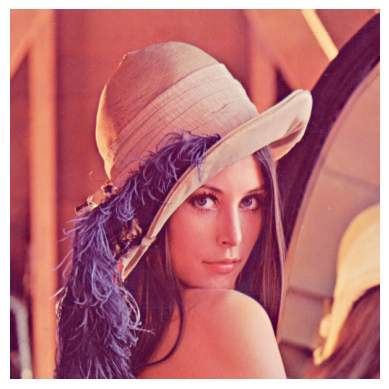

In [41]:
display_ori_image()

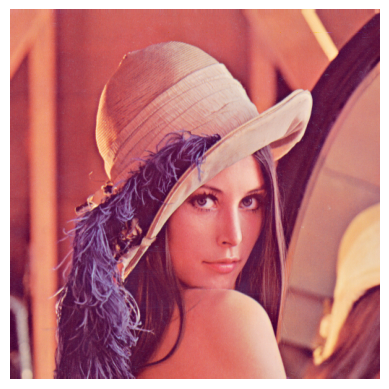

In [42]:
display_image('lsb_only.png')

## Stego Metric

In [43]:
calculate_stego_metrics("lsb_only.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_only.png):
MSE: 0.0009028116861979166
PSNR: 78.57483188820159
SSIM: 0.9999987952461553


(0.0009028116861979166, 78.57483188820159, 0.9999987952461553)

# LSB with ECC

In [44]:
ciphertext

b'\x04/:\xb7T\x04\xb5\xfe\x1b\xc3J\x92\x1a~(\xdd\xd8\xfd\x8c\x99\x1c\xd7\xba\x99\xdd\xa8\x0f\x02%"c\xcf\xcc\xc8eY\x0f\x17\xec\xd7c-\xdf\xb7\xce1\x85\x9a\xb9\x98\xc9Z\xa3\x92\x90\x0e\xf9\x16\xf8nbG\xdf\xd6\x9e\r\xf2\xd7\xbfv<@\xf6 (\x10S\x9b\xcb\x89\xf6\x12\xb6\xac\xc2\xb0!\x99\xe9r\xdc\xf8\xd2\xb1\xa16|\x0c\xd0%\xb2\xed\xa7\xfc\xcdK\xbfF\x1f\x95\x18\xfb\x8a\xc5\x1b\x12\xb6\xaa\xf4\x12\xb1\xc94\xe8\x00\xfc\xdd\xa176:\xa6\xaee\xb9\x91\x00\x0etI\xf0\xd3\xef\xe4\xa8!\x9f\xf9P\x91\xbc\x88\xa5]\xe7\x1bY\x9d\xa4tK.\xe7\x97>\x08|\xdf\x8f\x13\x1e\xcfW0\x07\xd9A\xcf\xed,v\x94u\x18N\xf3\x81p\xe32\x14\xd2\xe7\xbeE\xbc"D&\xc5;\x80\x1bT\xa1\xa1\xb3\xaf\xe4M\xf9R\x1al\x08\xa9a\xfc\xb0\x88\xfa\x85k\xa0,C\xbc\'CX\xd8uVQ#.\x16\xee\xedD\x10\xd4XVU\xd0~\xefV\xe0u\x84\xfb\xc3\xa9\x0c=\x07>o\xbe\x93\xc2n\xb4\x80R\xa7\xc6\xbdd*\x95\x81'

In [45]:
embed_lsb("lsb_w_ECC.png", ciphertext.hex())

In [46]:
embed_lsb("lsb_test.png", 'l')

In [47]:
extract_lsb("lsb_test.png")

'l'

In [48]:
calculate_stego_metrics("lsb_test.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_test.png):
MSE: 1.7801920572916668e-05
PSNR: 95.62613501860996
SSIM: 0.9999999738635894


(1.7801920572916668e-05, 95.62613501860996, 0.9999999738635894)

In [49]:
extracted_data = extract_lsb("lsb_w_ECC.png")
extracted_data

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

In [50]:
extracted_data == ciphertext.hex()

True

In [51]:
extracted_data = bytes.fromhex(extracted_data)
extracted_data

b'\x04/:\xb7T\x04\xb5\xfe\x1b\xc3J\x92\x1a~(\xdd\xd8\xfd\x8c\x99\x1c\xd7\xba\x99\xdd\xa8\x0f\x02%"c\xcf\xcc\xc8eY\x0f\x17\xec\xd7c-\xdf\xb7\xce1\x85\x9a\xb9\x98\xc9Z\xa3\x92\x90\x0e\xf9\x16\xf8nbG\xdf\xd6\x9e\r\xf2\xd7\xbfv<@\xf6 (\x10S\x9b\xcb\x89\xf6\x12\xb6\xac\xc2\xb0!\x99\xe9r\xdc\xf8\xd2\xb1\xa16|\x0c\xd0%\xb2\xed\xa7\xfc\xcdK\xbfF\x1f\x95\x18\xfb\x8a\xc5\x1b\x12\xb6\xaa\xf4\x12\xb1\xc94\xe8\x00\xfc\xdd\xa176:\xa6\xaee\xb9\x91\x00\x0etI\xf0\xd3\xef\xe4\xa8!\x9f\xf9P\x91\xbc\x88\xa5]\xe7\x1bY\x9d\xa4tK.\xe7\x97>\x08|\xdf\x8f\x13\x1e\xcfW0\x07\xd9A\xcf\xed,v\x94u\x18N\xf3\x81p\xe32\x14\xd2\xe7\xbeE\xbc"D&\xc5;\x80\x1bT\xa1\xa1\xb3\xaf\xe4M\xf9R\x1al\x08\xa9a\xfc\xb0\x88\xfa\x85k\xa0,C\xbc\'CX\xd8uVQ#.\x16\xee\xedD\x10\xd4XVU\xd0~\xefV\xe0u\x84\xfb\xc3\xa9\x0c=\x07>o\xbe\x93\xc2n\xb4\x80R\xa7\xc6\xbdd*\x95\x81'

In [52]:
decrypted_message = decrypt(private_key_hex, extracted_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [53]:
decrypted_message.decode() == CONTENT

True

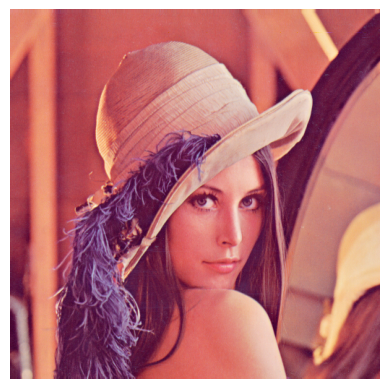

In [54]:
display_image('lsb_w_ECC.png')

## Stego Metric

In [55]:
calculate_stego_metrics("lsb_w_ECC.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC.png):
MSE: 0.0027758280436197915
PSNR: 73.69687801830095
SSIM: 0.9999930867856872


(0.0027758280436197915, 73.69687801830095, 0.9999930867856872)

In [56]:
len(CONTENT)

177

In [57]:
len(ciphertext.hex())

548

# LSB with LZW

In [58]:
compressed_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [59]:
embed_lsb("lsb_w_LZW.png", compressed_list)

In [60]:
extracted_data = extract_lsb("lsb_w_LZW.png")
extracted_data

'\x19\x8cÆ\x83\x81°Ä`4\x18\x0cG#q\x848j#1\x9a\x0eF\x93\x99ÐÞf2\x9c\x85FHÑ¤Ân\x15\x18\x8e¦Hùº.#:\x19Læ\x13`\x8e\x17\x0c\x16\x8c\x06s!\xa0\x8cØa5\x9aE³\x89Ð\x8cÄ#5\x1b\x05Â£\x84´Â*\x19\x0c\x85Fã}\x10f0\x11ÃêC\x11¸\x8cÚe5\x18NfShªTn\x96\x1a\x04f³\x91\x84Úa:Y-&\x83y°Òk\x9f\x99M\x87Zñ¬Âw4\x9b\x84g\x0b\x99\x86´r\x17Ú\r\x15¸©ÜÂ#;\x9b\x8d":åÔë\x1b4\x1aL\x87S\x84\x00'

In [61]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [62]:
compressed_list == byte_list

True

In [63]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [64]:
decompressed_text == CONTENT

True

## Stego Metric

In [65]:
calculate_stego_metrics("lsb_w_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_LZW.png):
MSE: 0.0008722941080729166
PSNR: 78.72417421832482
SSIM: 0.9999988544716335


(0.0008722941080729166, 78.72417421832482, 0.9999988544716335)

# LSB with ECC, LZW

## ECC

In [66]:
ciphertext.hex()

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

## LZW

In [67]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertext.hex()

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581
Original Bytes: b'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a

In [68]:
len(ciphertext.hex())

548

In [69]:
((548 - 416) / 548) *  100

24.087591240875913

In [70]:
548 / 132

4.151515151515151

In [71]:
percentage_ = (len(ciphertext.hex()) - len(compressed_list)) / len(ciphertext.hex()) * 100
percentage_

21.532846715328464

## LSB

In [72]:
compressed_list

[b'\x18',
 b'\r',
 b'\x06',
 b'F',
 b'a',
 b'\x99',
 b'\x84',
 b'\xc4',
 b'7',
 b'\x1a',
 b'\x8d',
 b' ',
 b'F',
 b'!',
 b'\xa9',
 b'\x98',
 b'\xca',
 b'1',
 b'1',
 b'\x18',
 b'\xc6',
 b'c',
 b'C',
 b'\x08',
 b'\xe4',
 b'd',
 b'1',
 b'0',
 b'\x8d',
 b'\xcc',
 b'\xa3',
 b'!',
 b'\xc1',
 b'\x92',
 b'>',
 b'8',
 b'3',
 b'\x19',
 b'\x07',
 b'\x06',
 b'1',
 b'\xc8',
 b'\xe4',
 b'b',
 b'c',
 b'2',
 b'\r',
 b'\xcc',
 b'Q',
 b'a',
 b'\xcc',
 b'|',
 b'\xc2',
 b'8',
 b'\x18',
 b'\x19',
 b'\x86',
 b'\x03',
 b'!',
 b'\x90',
 b'\xd6',
 b'j',
 b'6',
 b'\x19',
 b'\x98',
 b'\xcc',
 b'\xc6',
 b'9',
 b'\xe8',
 b'\xe0',
 b'l',
 b'5',
 b'\x1a',
 b'\x8e',
 b'f',
 b'C',
 b'\x18',
 b'\xdc',
 b'\xa4',
 b'o',
 b'9',
 b'\x19',
 b'G',
 b'\xcc',
 b'\xd0',
 b'\x83',
 b'\x19',
 b'\x94',
 b'f',
 b'1',
 b'\x1c',
 b'P',
 b'\xa0',
 b'\xf2',
 b'i',
 b' ',
 b'\xe4',
 b'j',
 b'a',
 b'0',
 b'\x8c',
 b'\xe2',
 b'\xf4',
 b'1',
 b'\x81',
 b'\x94',
 b'\xcd',
 b"'",
 b'\x1b',
 b'\x19',
 b'\xa7',
 b'\xe6',
 b'Q',
 b'\xb0',
 b'\x

In [73]:
embed_lsb("lsb_w_ECC_LZW.png", compressed_list)

In [74]:
extracted_data = extract_lsb("lsb_w_ECC_LZW.png")
extracted_data

"\x18\r\x06Fa\x99\x84Ä7\x1a\x8d F!©\x98Ê11\x18ÆcC\x08äd10\x8dÌ£!Á\x92>83\x19\x07\x061Èäbc2\rÌQaÌ|Â8\x18\x19\x86\x03!\x90Öj6\x19\x98ÌÆ9èàl5\x1a\x8efC\x18Ü¤o9\x19GÌÐ\x83\x19\x94f1\x1cP\xa0òi äja0\x8câô1\x81\x94Í'\x1b\x19§æQ°Èh72H\x86Ã\x93(ÂÕJ\x95\x99©\x13¨Y\x9aÍ4\x1c\x0cF\x03ZÜHÄ8\x1cÝÆ##\x10ØÃ=ÂÍ\x062c(äoJ\x9dÇ°±\x91\x88Ìl71\x8c%3A©\x88de2F§\x92\x91¡\x88Äf\x1a\r\x866\x01\xadF\x988Äk\x8cXL5gSµ\x94\x0eb\x86Y\x8cÊS¢Ë\ròðc\x0e\x1eË\x9e\x93^Æ\x15á¸Ði\x82·\x8cëæX¨â1\x82Ö\x8c$ñ!ÆÆ\x82d2\x8dâ4)q\x86ÑÏÏ\x99|Xþ\x98Àq\x99µHrÃ\x13,ìkÃæZG#ID<d\x0c\x865!üBU\x10Ñ_\x0c×\xa0Ý^\x0cÃ4`4\x80\x1e!\x89Õg\x864ÕÏ\x0c\x83a\x8d}`\x03\x07\x91\x15eF$\x19\x0fsÖ¥]\x18q\x99¦Ä9jÓÁ\x89ïHS\x00Ô6K\x13A\x8c4\x0cÑ ÉÎ\x0cÃTyðPT\x06\x12\x0eD\x03g\xad¡s×±\x904\x8f£7\x800FÕøÍnBC\x80ÑLDÑfl3\x19%\x07Mb\x84Û¸ZF\x18\x83DÅ7F\x868Ðd\r\x904Z>\x0cP\x00"

In [75]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x18',
 b'\r',
 b'\x06',
 b'F',
 b'a',
 b'\x99',
 b'\x84',
 b'\xc4',
 b'7',
 b'\x1a',
 b'\x8d',
 b' ',
 b'F',
 b'!',
 b'\xa9',
 b'\x98',
 b'\xca',
 b'1',
 b'1',
 b'\x18',
 b'\xc6',
 b'c',
 b'C',
 b'\x08',
 b'\xe4',
 b'd',
 b'1',
 b'0',
 b'\x8d',
 b'\xcc',
 b'\xa3',
 b'!',
 b'\xc1',
 b'\x92',
 b'>',
 b'8',
 b'3',
 b'\x19',
 b'\x07',
 b'\x06',
 b'1',
 b'\xc8',
 b'\xe4',
 b'b',
 b'c',
 b'2',
 b'\r',
 b'\xcc',
 b'Q',
 b'a',
 b'\xcc',
 b'|',
 b'\xc2',
 b'8',
 b'\x18',
 b'\x19',
 b'\x86',
 b'\x03',
 b'!',
 b'\x90',
 b'\xd6',
 b'j',
 b'6',
 b'\x19',
 b'\x98',
 b'\xcc',
 b'\xc6',
 b'9',
 b'\xe8',
 b'\xe0',
 b'l',
 b'5',
 b'\x1a',
 b'\x8e',
 b'f',
 b'C',
 b'\x18',
 b'\xdc',
 b'\xa4',
 b'o',
 b'9',
 b'\x19',
 b'G',
 b'\xcc',
 b'\xd0',
 b'\x83',
 b'\x19',
 b'\x94',
 b'f',
 b'1',
 b'\x1c',
 b'P',
 b'\xa0',
 b'\xf2',
 b'i',
 b' ',
 b'\xe4',
 b'j',
 b'a',
 b'0',
 b'\x8c',
 b'\xe2',
 b'\xf4',
 b'1',
 b'\x81',
 b'\x94',
 b'\xcd',
 b"'",
 b'\x1b',
 b'\x19',
 b'\xa7',
 b'\xe6',
 b'Q',
 b'\xb0',
 b'\x

In [76]:
compressed_list == byte_list

True

In [77]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581


In [78]:
decompressed_text == ciphertext.hex()

True

In [79]:
cipher_data = bytes.fromhex(decompressed_text)
cipher_data

b'\x04/:\xb7T\x04\xb5\xfe\x1b\xc3J\x92\x1a~(\xdd\xd8\xfd\x8c\x99\x1c\xd7\xba\x99\xdd\xa8\x0f\x02%"c\xcf\xcc\xc8eY\x0f\x17\xec\xd7c-\xdf\xb7\xce1\x85\x9a\xb9\x98\xc9Z\xa3\x92\x90\x0e\xf9\x16\xf8nbG\xdf\xd6\x9e\r\xf2\xd7\xbfv<@\xf6 (\x10S\x9b\xcb\x89\xf6\x12\xb6\xac\xc2\xb0!\x99\xe9r\xdc\xf8\xd2\xb1\xa16|\x0c\xd0%\xb2\xed\xa7\xfc\xcdK\xbfF\x1f\x95\x18\xfb\x8a\xc5\x1b\x12\xb6\xaa\xf4\x12\xb1\xc94\xe8\x00\xfc\xdd\xa176:\xa6\xaee\xb9\x91\x00\x0etI\xf0\xd3\xef\xe4\xa8!\x9f\xf9P\x91\xbc\x88\xa5]\xe7\x1bY\x9d\xa4tK.\xe7\x97>\x08|\xdf\x8f\x13\x1e\xcfW0\x07\xd9A\xcf\xed,v\x94u\x18N\xf3\x81p\xe32\x14\xd2\xe7\xbeE\xbc"D&\xc5;\x80\x1bT\xa1\xa1\xb3\xaf\xe4M\xf9R\x1al\x08\xa9a\xfc\xb0\x88\xfa\x85k\xa0,C\xbc\'CX\xd8uVQ#.\x16\xee\xedD\x10\xd4XVU\xd0~\xefV\xe0u\x84\xfb\xc3\xa9\x0c=\x07>o\xbe\x93\xc2n\xb4\x80R\xa7\xc6\xbdd*\x95\x81'

In [80]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [81]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [82]:
calculate_stego_metrics("lsb_w_ECC_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC_LZW.png):
MSE: 0.002197265625
PSNR: 74.7119779939636
SSIM: 0.9999952990621047


(0.002197265625, 74.7119779939636, 0.9999952990621047)

# LSB with Huffman

In [83]:
compressed_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [84]:
compressed_data.hex()

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [85]:
embed_lsb("lsb_w_Huffman.png", compressed_data.hex())

In [86]:
extracted_data = extract_lsb("lsb_w_Huffman.png")
extracted_data

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [87]:
len(extract_lsb("lsb_w_Huffman.png"))

216

In [88]:
len(CONTENT)

177

In [89]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [90]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')
Decompressed Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [91]:
decompressed_data.decode() == CONTENT

True

## Stego Metric

In [92]:
calculate_stego_metrics("lsb_w_Huffman.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_Huffman.png):
MSE: 0.00107574462890625
PSNR: 77.81371174500211
SSIM: 0.9999984186394683


(0.00107574462890625, 77.81371174500211, 0.9999984186394683)

# LSB with ECC, Huffman

## ECC

In [93]:
ciphertext.hex()

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

## Huffman

In [94]:
# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = ciphertext.hex().encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

Original Data (as bytes): b'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'
Original Data (as string): 042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224

## LSB

In [95]:
compressed_data

bytearray(b'\x08\xa5\xfe\x02\x83u\xa5\x87\xe6\xd8\xc0R\xbf\xd26\xf4\x99\x94\xe9L\xbb\xdc\x93\x82\xbb\x99$\xae\xaf\xf7\xff\x10\xce\xcc\xc4\x17{\xae\xd3l\x93\x10\xf9\x9e\x83\xc6\rG\xb2\x8b\xb4\xcbr \xbf\xba\xa6\xeb\xd1\xe4\x16\x1fS\x9e\x91\xb6\xa9\xef\x93\x8e1\x0cZ\xe1\xfa\xf4\xdap\xb8\xc8K\xe1\xdf\x81,\xcf\x8a\xfd\xbbk?\x9c\xe4\x9f\x8d-\x01<\xac\x9a\xf7\x8fi#\xec\xc9X\x8eQ\xde\xb7\xd4\xe8B\xc7\xd8\xdf\x81"\xe5\xdf\x8d\xcb\x05d\xaa\xec\x99-\x03\x01\x02!&\x17\x8b\xbd\xaa\xa65[\xea\x90ne$\xfd\xbe\xebz\xbd\x8cD\'yc\xd8{\xb9%5X\xf6c\xb3\x06\xa4<\x9eN\xd0\xd6\xces\n\xa3\x9b]\xcei\xfc1\xb57\xd4V\xe0M:`\x0f\xd5\x9fc\x86W\x8c\xffU\xf1\xc7\x08J\xd8u--\x80.eY\xeb\x7f\xd2\x1c\xa4+\x1d\xec\x8aD\xe2G\x18*\xfcP\x8c\xf3Pt\x947q}\xf0\xf6\xd1fiU\xda\x95tqw\x9a6nqj7E\xe8\xc0+\xac\t\xa3\x06\x1e\x86\xb0\xcf\x16\x85J\x7f#\xc1\x89\x15\xf2\xb7M\x00')

In [96]:
compressed_data.hex()

'08a5fe028375a587e6d8c052bfd236f49994e94cbbdc9382bb9924aeaff7ff10ceccc4177baed36c9310f99e83c60d47b28bb4cb7220bfbaa6ebd1e4161f539e91b6a9ef938e310c5ae1faf4da70b8c84be1df812ccf8afdbb6b3f9ce49f8d2d013cac9af78f6923ecc9588e51deb7d4e842c7d8df8122e5df8dcb0564aaec992d0301022126178bbdaaa6355bea906e6524fdbeeb7abd8c44277963d87bb9253558f663b306a43c9e4ed0d6ce730aa39b5dce69fc31b537d456e04d3a600fd59f6386578cff55f1c7084ad8752d2d802e6559eb7fd21ca42b1dec8a44e247182afc508cf350749437717df0f6d1666955da957471779a366e716a3745e8c02bac09a3061e86b0cf16854a7f23c18915f2b74d00'

In [97]:
len(compressed_data.hex())

552

In [98]:
len(ciphertext.hex())

548

In [99]:
embed_lsb('LSB_w_ECC_Huffman.png', compressed_data.hex())

In [100]:
extracted_data = extract_lsb('LSB_w_ECC_Huffman.png')
extracted_data

'08a5fe028375a587e6d8c052bfd236f49994e94cbbdc9382bb9924aeaff7ff10ceccc4177baed36c9310f99e83c60d47b28bb4cb7220bfbaa6ebd1e4161f539e91b6a9ef938e310c5ae1faf4da70b8c84be1df812ccf8afdbb6b3f9ce49f8d2d013cac9af78f6923ecc9588e51deb7d4e842c7d8df8122e5df8dcb0564aaec992d0301022126178bbdaaa6355bea906e6524fdbeeb7abd8c44277963d87bb9253558f663b306a43c9e4ed0d6ce730aa39b5dce69fc31b537d456e04d3a600fd59f6386578cff55f1c7084ad8752d2d802e6559eb7fd21ca42b1dec8a44e247182afc508cf350749437717df0f6d1666955da957471779a366e716a3745e8c02bac09a3061e86b0cf16854a7f23c18915f2b74d00'

In [101]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x08\xa5\xfe\x02\x83u\xa5\x87\xe6\xd8\xc0R\xbf\xd26\xf4\x99\x94\xe9L\xbb\xdc\x93\x82\xbb\x99$\xae\xaf\xf7\xff\x10\xce\xcc\xc4\x17{\xae\xd3l\x93\x10\xf9\x9e\x83\xc6\rG\xb2\x8b\xb4\xcbr \xbf\xba\xa6\xeb\xd1\xe4\x16\x1fS\x9e\x91\xb6\xa9\xef\x93\x8e1\x0cZ\xe1\xfa\xf4\xdap\xb8\xc8K\xe1\xdf\x81,\xcf\x8a\xfd\xbbk?\x9c\xe4\x9f\x8d-\x01<\xac\x9a\xf7\x8fi#\xec\xc9X\x8eQ\xde\xb7\xd4\xe8B\xc7\xd8\xdf\x81"\xe5\xdf\x8d\xcb\x05d\xaa\xec\x99-\x03\x01\x02!&\x17\x8b\xbd\xaa\xa65[\xea\x90ne$\xfd\xbe\xebz\xbd\x8cD\'yc\xd8{\xb9%5X\xf6c\xb3\x06\xa4<\x9eN\xd0\xd6\xces\n\xa3\x9b]\xcei\xfc1\xb57\xd4V\xe0M:`\x0f\xd5\x9fc\x86W\x8c\xffU\xf1\xc7\x08J\xd8u--\x80.eY\xeb\x7f\xd2\x1c\xa4+\x1d\xec\x8aD\xe2G\x18*\xfcP\x8c\xf3Pt\x947q}\xf0\xf6\xd1fiU\xda\x95tqw\x9a6nqj7E\xe8\xc0+\xac\t\xa3\x06\x1e\x86\xb0\xcf\x16\x85J\x7f#\xc1\x89\x15\xf2\xb7M\x00')

In [102]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581')
Decompressed Data (as string): 042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170

In [103]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

b'\x04/:\xb7T\x04\xb5\xfe\x1b\xc3J\x92\x1a~(\xdd\xd8\xfd\x8c\x99\x1c\xd7\xba\x99\xdd\xa8\x0f\x02%"c\xcf\xcc\xc8eY\x0f\x17\xec\xd7c-\xdf\xb7\xce1\x85\x9a\xb9\x98\xc9Z\xa3\x92\x90\x0e\xf9\x16\xf8nbG\xdf\xd6\x9e\r\xf2\xd7\xbfv<@\xf6 (\x10S\x9b\xcb\x89\xf6\x12\xb6\xac\xc2\xb0!\x99\xe9r\xdc\xf8\xd2\xb1\xa16|\x0c\xd0%\xb2\xed\xa7\xfc\xcdK\xbfF\x1f\x95\x18\xfb\x8a\xc5\x1b\x12\xb6\xaa\xf4\x12\xb1\xc94\xe8\x00\xfc\xdd\xa176:\xa6\xaee\xb9\x91\x00\x0etI\xf0\xd3\xef\xe4\xa8!\x9f\xf9P\x91\xbc\x88\xa5]\xe7\x1bY\x9d\xa4tK.\xe7\x97>\x08|\xdf\x8f\x13\x1e\xcfW0\x07\xd9A\xcf\xed,v\x94u\x18N\xf3\x81p\xe32\x14\xd2\xe7\xbeE\xbc"D&\xc5;\x80\x1bT\xa1\xa1\xb3\xaf\xe4M\xf9R\x1al\x08\xa9a\xfc\xb0\x88\xfa\x85k\xa0,C\xbc\'CX\xd8uVQ#.\x16\xee\xedD\x10\xd4XVU\xd0~\xefV\xe0u\x84\xfb\xc3\xa9\x0c=\x07>o\xbe\x93\xc2n\xb4\x80R\xa7\xc6\xbdd*\x95\x81'

In [104]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [105]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [106]:
calculate_stego_metrics('LSB_w_ECC_Huffman.png')

Metrics between original (ori-image/lena.png) and stego image (LSB_w_ECC_Huffman.png):
MSE: 0.0027669270833333335
PSNR: 73.71082646513092
SSIM: 0.999993256738695


(0.0027669270833333335, 73.71082646513092, 0.999993256738695)

# Test

In [107]:
ciphertexts

'W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ=='

In [108]:
embed_lsb("lsb_tests.png", ciphertexts)

In [109]:
512 * 512 * 3

786432

In [110]:
extract_lsb("lsb_tests.png")

'W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ=='

In [111]:
extract_lsb("lsb_tests.png") == ciphertexts

True

In [112]:
calculate_stego_metrics("lsb_tests.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_tests.png):
MSE: 0.001743316650390625
PSNR: 75.71704082749721
SSIM: 0.9999966149367551


(0.001743316650390625, 75.71704082749721, 0.9999966149367551)

In [113]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertexts

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ==
Original Bytes: b'W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ=='
Compressed List (Byte Chunks): [b'+', b'\x8c', b'N', b'\x86', b'"', b'q', b'\x10', b'\x8a', b'3', b'&', b'\x10', b'\xc8', b"'", b'\x82', b'q', b'P', b'\xd0', b'd', b'\x85', b'\x10', b'\x8c', b'D', b'\xd3', b'\xd1', b'\x04', b'a', b'\n', b' ', b'\x8c', b'I', b'\xe4', 

In [114]:
embed_lsb("lsb_test_again.png", compressed_list)

In [115]:
compressed_list

[b'+',
 b'\x8c',
 b'N',
 b'\x86',
 b'"',
 b'q',
 b'\x10',
 b'\x8a',
 b'3',
 b'&',
 b'\x10',
 b'\xc8',
 b"'",
 b'\x82',
 b'q',
 b'P',
 b'\xd0',
 b'd',
 b'\x85',
 b'\x10',
 b'\x8c',
 b'D',
 b'\xd3',
 b'\xd1',
 b'\x04',
 b'a',
 b'\n',
 b' ',
 b'\x8c',
 b'I',
 b'\xe4',
 b'B',
 b'\xd1',
 b'\x90',
 b'\xb0',
 b'S',
 b';',
 b'\x99',
 b'\xe0',
 b'G',
 b'1',
 b'\x81',
 b'4',
 b'\xa8',
 b'c',
 b'9',
 b'\x92',
 b'`',
 b'\xf1',
 b'\xb2',
 b'0',
 b'\xc2',
 b'T',
 b'F',
 b'\x92',
 b'\xc1',
 b'\x8b',
 b'2',
 b'\xa2',
 b'!',
 b'T',
 b'\xf4',
 b'M',
 b'6',
 b'\x0c',
 b'b',
 b'$',
 b'8',
 b'\x99',
 b'\\',
 b'\xf4',
 b'Q',
 b'\x86',
 b'\x9e',
 b'd',
 b'R',
 b'r',
 b'\xa8',
 b'\xd2',
 b'A',
 b'"',
 b'\x9f',
 b'\x96',
 b'F',
 b'\xa4',
 b'\xe3',
 b'L',
 b'\x88',
 b'\x9e',
 b'T',
 b'!',
 b'G',
 b'\xe4',
 b'2',
 b'1',
 b'\x8c',
 b'\x96',
 b'O',
 b')',
 b'\x95',
 b'\x91',
 b'e',
 b'\xb2',
 b'\xf2',
 b'L',
 b'\xc6',
 b'M',
 b'T',
 b'&',
 b'\x9a',
 b'\x8c',
 b'c',
 b'\x02',
 b'\xc1',
 b'Z',
 b'\xba',
 b'F',
 b'\x

In [116]:
ext_data = extract_lsb("lsb_test_again.png")
ext_data

'+\x8cN\x86"q\x10\x8a3&\x10È\'\x82qPÐd\x85\x10\x8cDÓÑ\x04a\n \x8cIäBÑ\x90°S;\x99àG1\x814¨c9\x92`ñ²0ÂTF\x92Á\x8b2¢!TôM6\x0cb$8\x99\\ôQ\x86\x9edRr¨ÒA"\x9f\x96F¤ãL\x88\x9eT!Gä21\x8c\x96O)\x95\x91e²òLÆMT&\x9a\x8cc\x02ÁZºF\x82A¡\x11\x98l>y\x13\x83\x10F±\x91\x818õR¤Ujò\x89\xadl\x9f.\x98\x1cÆQÂ\x8døðO+NâF)ý\x04\x9dC3ÑhõJUÚ\x9d\x92*\x16O6kEª\x0f\t\x85Û¢\x18È©4ó\x19\x18\x93HØ¹î6\x81B¢\x15(×©ù$i\x19\x9c\x11\tU:MZM}\xadW0G\x9816k\x8fÅGÊ#Ñì\x00'

In [117]:
byte_list = [bytes([ord(char)]) for char in ext_data]
byte_list

[b'+',
 b'\x8c',
 b'N',
 b'\x86',
 b'"',
 b'q',
 b'\x10',
 b'\x8a',
 b'3',
 b'&',
 b'\x10',
 b'\xc8',
 b"'",
 b'\x82',
 b'q',
 b'P',
 b'\xd0',
 b'd',
 b'\x85',
 b'\x10',
 b'\x8c',
 b'D',
 b'\xd3',
 b'\xd1',
 b'\x04',
 b'a',
 b'\n',
 b' ',
 b'\x8c',
 b'I',
 b'\xe4',
 b'B',
 b'\xd1',
 b'\x90',
 b'\xb0',
 b'S',
 b';',
 b'\x99',
 b'\xe0',
 b'G',
 b'1',
 b'\x81',
 b'4',
 b'\xa8',
 b'c',
 b'9',
 b'\x92',
 b'`',
 b'\xf1',
 b'\xb2',
 b'0',
 b'\xc2',
 b'T',
 b'F',
 b'\x92',
 b'\xc1',
 b'\x8b',
 b'2',
 b'\xa2',
 b'!',
 b'T',
 b'\xf4',
 b'M',
 b'6',
 b'\x0c',
 b'b',
 b'$',
 b'8',
 b'\x99',
 b'\\',
 b'\xf4',
 b'Q',
 b'\x86',
 b'\x9e',
 b'd',
 b'R',
 b'r',
 b'\xa8',
 b'\xd2',
 b'A',
 b'"',
 b'\x9f',
 b'\x96',
 b'F',
 b'\xa4',
 b'\xe3',
 b'L',
 b'\x88',
 b'\x9e',
 b'T',
 b'!',
 b'G',
 b'\xe4',
 b'2',
 b'1',
 b'\x8c',
 b'\x96',
 b'O',
 b')',
 b'\x95',
 b'\x91',
 b'e',
 b'\xb2',
 b'\xf2',
 b'L',
 b'\xc6',
 b'M',
 b'T',
 b'&',
 b'\x9a',
 b'\x8c',
 b'c',
 b'\x02',
 b'\xc1',
 b'Z',
 b'\xba',
 b'F',
 b'\x

In [118]:
compressed_list == byte_list

True

In [119]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ==


In [120]:
decompressed_text == ciphertexts

True

In [121]:
ciphertexts

'W1tbNDE3LCAxNThdLCBbMzA0LCA1ODZdXSwgW1s0MTcsIDE1OF0sIFs0NDYsIDUzMl1dLCBbWzQxNywgMTU4XSwgWzY5NiwgOTBdXSwgW1s0MTcsIDE1OF0sIFs0MSwgMjc0XV0sIFtbNDE3LCAxNThdLCBbNDA5LCA0NzBdXSwgW1s0MTcsIDE1OF0sIFs2ODQsIDExOV1dLCBbWzQxNywgMTU4XSwgWzY0NiwgMTYyXV0sIFtbNDE3LCAxNThdLCBbMzMyLCA1MF1dLCBbWzQxNywgMTU4XSwgWzI4LCAzMDJdXSwgW1s0MTcsIDE1OF0sIFsyNDMsIDQxNV1dXQ=='

In [122]:
len(ciphertexts)

344

In [123]:
calculate_stego_metrics("lsb_test_again.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_test_again.png):
MSE: 0.0011965433756510417
PSNR: 77.35151914111978
SSIM: 0.9999981852173245


(0.0011965433756510417, 77.35151914111978, 0.9999981852173245)

# Huffman 2

In [124]:
!git clone https://github.com/w-henderson/Huffpy.git

Cloning into 'Huffpy'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 40 (delta 10), reused 40 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 602.50 KiB | 24.10 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [125]:
!python Huffpy/setup.py install

Traceback (most recent call last):
  File "/content/Huffpy/setup.py", line 3, in <module>
    with open("README.md", "r") as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'README.md'


In [126]:
import Huffpy.huffpy as huffpy

coder = huffpy.HuffmanCoder()
stringToEncode = CONTENT

huffmanString, tree = coder.encode(stringToEncode)
huffmanBytes = coder.toBytes(huffmanString, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)

stringToEncode == decodedString

True

In [127]:
huffmanBytes

bytearray(b'\x00\x00\x03V[[[[[["o",["2",["f","/"]]],["3","1"]],"#"],[[[["g","."],"4"],"r"],[["d","b"],["9","7"]]]],[[[["p","w"],["-","j"]],["k","m"]],[["t","n"],"0"]]],[[["i",["u",[[["6","c"],"8"],"5"]]],[["h","s"],"e"]],["a",["*","l"]]]]\x08"f\xcc\x06\xe4\xb8g\x1e\xee\xf3\x8c\xcd\x0b\x15`\x00\xd6^2\xcb\x19\xbcl\x8c\x8c\xd6\x00,\xb2\x1b\xc43\x8e=\'\t\'$\x7f*\x12\xfc\xa8\x13E?#\xc8o\xdc\x08\x174\x02<\x13\x8b\xbc\xe2\xe1\x9e+\xb4\xf5m|\xcbi\rAQr\xf3\x05Y\x94\x03\xe1Bm\xfc\x97\xca\xc8\xc3E\x0b\xfc\x9e(:\xf55b\xa8\xe1E\xb05\xb9.E\xeaA\x92@')

In [128]:
decodedHuffmanString

'00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [129]:
print(f"Panjang stringToEncode: {len(stringToEncode)}")
print(f"Panjang huffmanString: {len(huffmanString)}")
print(f"Panjang huffmanBytes: {len(huffmanBytes)}")
print(f"Panjang decodedHuffmanString: {len(decodedHuffmanString)}")
print(f"Panjang decodedString: {len(decodedString)}")

Panjang stringToEncode: 177
Panjang huffmanString: 854
Panjang huffmanBytes: 324
Panjang decodedHuffmanString: 854
Panjang decodedString: 177


In [130]:
huffmanString

'00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [131]:
# Function to convert binary string to text (ASCII)
def binary_to_ascii(binary_str):
    # Ensure the binary string is divisible by 8
    if len(binary_str) % 8 != 0:
        raise ValueError("The binary string length is not divisible by 8.")

    # Convert binary values to ASCII text
    binary_values = [binary_str[i:i+8] for i in range(0, len(binary_str), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]

    return ''.join(ascii_characters)

# Function to convert ASCII text back to binary string
def ascii_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

In [132]:
# Function to convert binary string to text (ASCII) and handle non-divisible by 8 lengths
def binary_to_ascii_with_padding(binary_str):
    # Add '00' padding if the binary string is not divisible by 8
    padding_length = 8 - (len(binary_str) % 8)
    if padding_length != 8:
        binary_str = binary_str + '0' * padding_length

    # Convert binary values to ASCII text
    binary_values = [binary_str[i:i+8] for i in range(0, len(binary_str), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]

    return ''.join(ascii_characters), padding_length

# Function to convert ASCII text back to binary string and remove padding if needed
def ascii_to_binary_with_padding(text, padding_length):
    binary_str = ''.join(format(ord(char), '08b') for char in text)
    # Remove the padding that was added earlier
    return binary_str[:-padding_length] if padding_length != 8 else binary_str

# Your binary string (with a length not divisible by 8)
binary_string = huffmanString

# Convert binary to ASCII text with padding
ascii_message, padding_length = binary_to_ascii_with_padding(binary_string)

# Convert the ASCII message back to binary and remove padding
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)

ascii_message, binary_back  # Display the ASCII message and the binary string

('\x08"fÌ\x06ä¸g\x1eîó\x8cÍ\x0b\x15`\x00Ö^2Ë\x19¼l\x8c\x8cÖ\x00,²\x1bÄ3\x8e=\'\t\'$\x7f*\x12ü¨\x13E?#ÈoÜ\x08\x174\x02<\x13\x8b¼âá\x9e+´õm|Ëi\rAQró\x05Y\x94\x03áBmü\x97ÊÈÃE\x0bü\x9e(:õ5b¨áE°5¹.EêA\x92@',
 '000010000010001001100110110011000000011011100100101110000110011100011110111011101111001110001100110011010000101100010101011000000000000011010110010111100011001011001011000110011011110001101100100011001000110011010110000000000010110010110010000110111100010000110011100011100011110100100111000010010010011100100100011111110010101000010010111111001010100000010011010001010011111100100011110010000110111111011100000010000001011100110100000000100011110000010011100010111011110011100010111000011001111000101011101101001111010101101101011111001100101101101001000011010100000101010001011100101111001100000101010110011001010000000011111000010100001001101101111111001001011111001010110010001100001101000101000010111111110010011110001010000011101011110101001101010110001010101000111000010100010110110000001

In [133]:
binary_back == binary_string

True

In [134]:
len(CONTENT)

177

In [135]:
len(ascii_message)

107

# LSB with Huffman 2

In [136]:
embed_lsb("lsb_w_Huffman2.png", ascii_message)

In [137]:
len(ascii_message)

107

In [138]:
extracted_data = extract_lsb("lsb_w_Huffman2.png")
extracted_data

'\x08"fÌ\x06ä¸g\x1eîó\x8cÍ\x0b\x15`\x00Ö^2Ë\x19¼l\x8c\x8cÖ\x00,²\x1bÄ3\x8e=\'\t\'$\x7f*\x12ü¨\x13E?#ÈoÜ\x08\x174\x02<\x13\x8b¼âá\x9e+´õm|Ëi\rAQró\x05Y\x94\x03áBmü\x97ÊÈÃE\x0bü\x9e(:õ5b¨áE°5¹.EêA\x92@'

In [139]:
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)
binary_back

'00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [140]:
binary_back == huffmanString

True

In [141]:
huffmanBytes = coder.toBytes(binary_back, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)
decodedString

'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'

## Stego Metric

In [142]:
calculate_stego_metrics("lsb_w_Huffman2.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_Huffman2.png):
MSE: 0.00057220458984375
PSNR: 80.5552902376389
SSIM: 0.9999991737848752


(0.00057220458984375, 80.5552902376389, 0.9999991737848752)

# LSB with ECC, Huffman 2

In [143]:
ciphertext.hex()

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

In [144]:
import Huffpy.huffpy as huffpy

coder = huffpy.HuffmanCoder()
stringToEncode = ciphertext.hex()

huffmanString, tree = coder.encode(stringToEncode)
huffmanString

'010110100000000111111100100011011001101001011010100010010001011000101000001111111010110001000000001011001101011000001011011101110111101100010111101100110100010000100011011111011000110001000100011101111100101101010001010100000000100100000000111011110011000100110011001110111110100110010100010100010010110101100011011111011110111100000111011100011000110100110110111100101011100101001100100001000100101100110100100111001100111101000000010001010101011000010100001011100001101111100110111000001010110101110001011111100100011001010111000100000111110110000001110111101111001110100101000111100000010100001011001001011001111101001000001110001011010000011110001000001000111011000011001100001000010100000010010001000110010011010000011100110001101101110000100000101100001011111110110100110101001101110101000010011000000001100111110011010001001100110111101010001000000110101110001000010100100100101011000110001011110000111001001010000010000010001110110011000001101000100000100000100011010011111010011010110101010

In [145]:
ascii_message, padding_length = binary_to_ascii_with_padding(huffmanString)
ascii_message

'Z\x01ü\x8d\x9aZ\x89\x16(?¬@,Ö\x0bw{\x17³D#}\x8cDwËQP\t\x00ï13;é\x94Q-c}ï\x07q\x8d6ò¹L\x84K4\x9cÏ@EV\x14.\x1bæà\xadq~FW\x10}\x81Þó¥\x1e\x05\x0b%\x9fH8´\x1e \x8eÃ0\x85\x02DdÐs\x1bp\x82ÂþÓSu\t\x80gÍ\x137¨\x81®!I+\x18¼9( \x8eÌ\x1a \x824úkU\x13wÂýþüÎÆé\x84BUVÚ¤\x15\x7fajË\x02A\x14\x95B\x83»É\x97m(\x94GÊÚ¨\x06mMö[Óq±/&1\x9dõ]t¢1g\x03ÞJÙ+¦\x1f²Õoð*pm\x86©\x83\x00ª\x0e9øµ(\x9aÂÂ\x8fÁj§\x14\x90,ã[Äâ\x13\x85»\x1c¹èÅ\x03¯\x83\r¯\x9b{Ù\x9e\x92\x0f\x06.fgª%z\x9b\x9e\x99uÖa\x9eeÙº\x18?ÄS÷]öá\x86O0æ\x8aµ\x90Í>\x87ê\x0cI²'

In [146]:
len(ascii_message), len(ciphertext.hex())

(274, 548)

In [147]:
((548 - 274) / 548) *  100

50.0

In [148]:
embed_lsb("lsb_w_ECC_Huffman2.png", ascii_message)

In [149]:
extracted_data = extract_lsb("lsb_w_ECC_Huffman2.png")
extracted_data

'Z\x01ü\x8d\x9aZ\x89\x16(?¬@,Ö\x0bw{\x17³D#}\x8cDwËQP\t\x00ï13;é\x94Q-c}ï\x07q\x8d6ò¹L\x84K4\x9cÏ@EV\x14.\x1bæà\xadq~FW\x10}\x81Þó¥\x1e\x05\x0b%\x9fH8´\x1e \x8eÃ0\x85\x02DdÐs\x1bp\x82ÂþÓSu\t\x80gÍ\x137¨\x81®!I+\x18¼9( \x8eÌ\x1a \x824úkU\x13wÂýþüÎÆé\x84BUVÚ¤\x15\x7fajË\x02A\x14\x95B\x83»É\x97m(\x94GÊÚ¨\x06mMö[Óq±/&1\x9dõ]t¢1g\x03ÞJÙ+¦\x1f²Õoð*pm\x86©\x83\x00ª\x0e9øµ(\x9aÂÂ\x8fÁj§\x14\x90,ã[Äâ\x13\x85»\x1c¹èÅ\x03¯\x83\r¯\x9b{Ù\x9e\x92\x0f\x06.fgª%z\x9b\x9e\x99uÖa\x9eeÙº\x18?ÄS÷]öá\x86O0æ\x8aµ\x90Í>\x87ê\x0cI²'

In [150]:
binary_back = ascii_to_binary_with_padding(ascii_message, padding_length)
binary_back

'010110100000000111111100100011011001101001011010100010010001011000101000001111111010110001000000001011001101011000001011011101110111101100010111101100110100010000100011011111011000110001000100011101111100101101010001010100000000100100000000111011110011000100110011001110111110100110010100010100010010110101100011011111011110111100000111011100011000110100110110111100101011100101001100100001000100101100110100100111001100111101000000010001010101011000010100001011100001101111100110111000001010110101110001011111100100011001010111000100000111110110000001110111101111001110100101000111100000010100001011001001011001111101001000001110001011010000011110001000001000111011000011001100001000010100000010010001000110010011010000011100110001101101110000100000101100001011111110110100110101001101110101000010011000000001100111110011010001001100110111101010001000000110101110001000010100100100101011000110001011110000111001001010000010000010001110110011000001101000100000100000100011010011111010011010110101010

In [151]:
binary_back == huffmanString

True

In [152]:
huffmanBytes = coder.toBytes(binary_back, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)
decodedString

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

In [153]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

b'\x04/:\xb7T\x04\xb5\xfe\x1b\xc3J\x92\x1a~(\xdd\xd8\xfd\x8c\x99\x1c\xd7\xba\x99\xdd\xa8\x0f\x02%"c\xcf\xcc\xc8eY\x0f\x17\xec\xd7c-\xdf\xb7\xce1\x85\x9a\xb9\x98\xc9Z\xa3\x92\x90\x0e\xf9\x16\xf8nbG\xdf\xd6\x9e\r\xf2\xd7\xbfv<@\xf6 (\x10S\x9b\xcb\x89\xf6\x12\xb6\xac\xc2\xb0!\x99\xe9r\xdc\xf8\xd2\xb1\xa16|\x0c\xd0%\xb2\xed\xa7\xfc\xcdK\xbfF\x1f\x95\x18\xfb\x8a\xc5\x1b\x12\xb6\xaa\xf4\x12\xb1\xc94\xe8\x00\xfc\xdd\xa176:\xa6\xaee\xb9\x91\x00\x0etI\xf0\xd3\xef\xe4\xa8!\x9f\xf9P\x91\xbc\x88\xa5]\xe7\x1bY\x9d\xa4tK.\xe7\x97>\x08|\xdf\x8f\x13\x1e\xcfW0\x07\xd9A\xcf\xed,v\x94u\x18N\xf3\x81p\xe32\x14\xd2\xe7\xbeE\xbc"D&\xc5;\x80\x1bT\xa1\xa1\xb3\xaf\xe4M\xf9R\x1al\x08\xa9a\xfc\xb0\x88\xfa\x85k\xa0,C\xbc\'CX\xd8uVQ#.\x16\xee\xedD\x10\xd4XVU\xd0~\xefV\xe0u\x84\xfb\xc3\xa9\x0c=\x07>o\xbe\x93\xc2n\xb4\x80R\xa7\xc6\xbdd*\x95\x81'

In [154]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


## Stego Metric

In [155]:
calculate_stego_metrics("lsb_w_ECC_Huffman2.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC_Huffman2.png):
MSE: 0.001384735107421875
PSNR: 76.7171365778346
SSIM: 0.9999974485212874


(0.001384735107421875, 76.7171365778346, 0.9999974485212874)

In [156]:
extract_lsb('lsb_only.png')

'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'

In [157]:
extract_lsb('lsb_w_ECC.png')

'042f3ab75404b5fe1bc34a921a7e28ddd8fd8c991cd7ba99dda80f02252263cfccc865590f17ecd7632ddfb7ce31859ab998c95aa392900ef916f86e6247dfd69e0df2d7bf763c40f6202810539bcb89f612b6acc2b02199e972dcf8d2b1a1367c0cd025b2eda7fccd4bbf461f9518fb8ac51b12b6aaf412b1c934e800fcdda137363aa6ae65b991000e7449f0d3efe4a8219ff95091bc88a55de71b599da4744b2ee7973e087cdf8f131ecf573007d941cfed2c769475184ef38170e33214d2e7be45bc224426c53b801b54a1a1b3afe44df9521a6c08a961fcb088fa856ba02c43bc274358d8755651232e16eeed4410d4585655d07eef56e07584fbc3a90c3d073e6fbe93c26eb48052a7c6bd642a9581'

array([[[226, 136, 124],
        [226, 136, 124],
        [223, 136, 132],
        ...,
        [230, 148, 122],
        [221, 130, 110],
        [200,  99,  90]],

       [[226, 137, 125],
        [226, 137, 125],
        [223, 137, 133],
        ...,
        [230, 148, 122],
        [221, 130, 110],
        [200,  99,  90]],

       [[226, 137, 125],
        [226, 137, 125],
        [223, 137, 133],
        ...,
        [230, 148, 122],
        [221, 130, 110],
        [200,  99,  90]],

       ...,

       [[ 84,  18,  60],
        [ 84,  18,  60],
        [ 92,  27,  58],
        ...,
        [173,  73,  84],
        [172,  68,  76],
        [177,  62,  79]],

       [[ 82,  22,  57],
        [ 82,  22,  57],
        [ 96,  32,  62],
        ...,
        [179,  70,  79],
        [181,  71,  81],
        [185,  74,  81]],

       [[ 82,  22,  57],
        [ 82,  22,  57],
        [ 96,  32,  62],
        ...,
        [179,  70,  79],
        [181,  71,  81],
        [185,  74,  81]]], dtype=uint8)
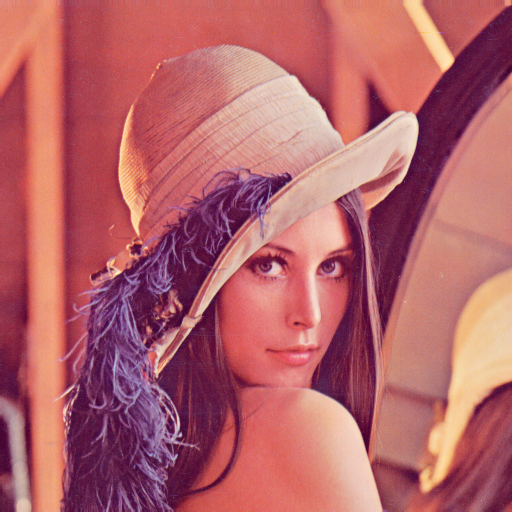

In [158]:
# read rgb of image
def read_rgb(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    return img_array

read_rgb('stego-image/lsb_only.png')

array([[[226, 136, 124],
        [226, 136, 124],
        [222, 136, 133],
        ...,
        [230, 148, 123],
        [220, 131, 111],
        [201,  98,  90]],

       [[227, 136, 124],
        [226, 136, 125],
        [222, 137, 133],
        ...,
        [230, 148, 123],
        [220, 131, 111],
        [200,  98,  91]],

       [[227, 137, 124],
        [227, 136, 124],
        [222, 136, 132],
        ...,
        [230, 148, 122],
        [221, 130, 110],
        [200,  99,  90]],

       ...,

       [[ 84,  18,  60],
        [ 84,  18,  60],
        [ 92,  27,  58],
        ...,
        [173,  73,  84],
        [172,  68,  76],
        [177,  62,  79]],

       [[ 82,  22,  57],
        [ 82,  22,  57],
        [ 96,  32,  62],
        ...,
        [179,  70,  79],
        [181,  71,  81],
        [185,  74,  81]],

       [[ 82,  22,  57],
        [ 82,  22,  57],
        [ 96,  32,  62],
        ...,
        [179,  70,  79],
        [181,  71,  81],
        [185,  74,  81]]], dtype=uint8)
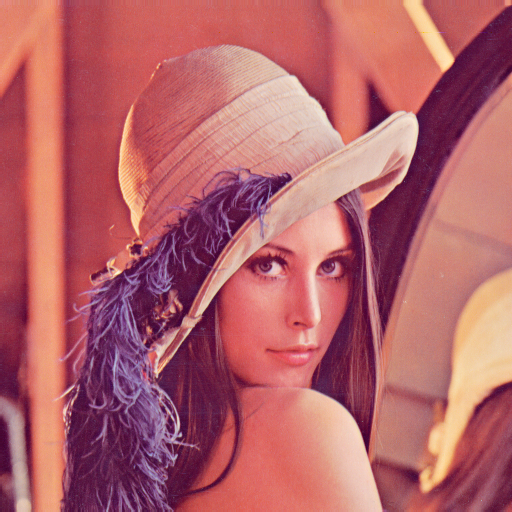

In [159]:
read_rgb('stego-image/lsb_w_ECC.png')

# Max capacity for 32% PSNR

In [160]:
capacity_test = "lorem"

In [161]:
embed_lsb("lsb_w_capacity_test.png", capacity_test)

In [162]:
extracted_data = extract_lsb("lsb_w_capacity_test.png")
extracted_data

'lorem'

In [163]:
calculate_stego_metrics("lsb_w_capacity_test.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 4.1961669921875e-05
PSNR: 91.90227597661347
SSIM: 0.9999999318858996


(4.1961669921875e-05, 91.90227597661347, 0.9999999318858996)

In [164]:
# Starting with a small amount of data for embedding
capacity_test = "lorem"

# Loop variables
psnr_threshold = 32
current_psnr = 100  # Start with a very high PSNR
counter = 1

while current_psnr > psnr_threshold:
    # Generate new data to embed (increase data size)
    capacity_test = capacity_test * 2

    # Embed data into the image
    embed_lsb("lsb_w_capacity_test.png", capacity_test)

    extracted_data = extract_lsb("lsb_w_capacity_test.png")

    # Calculate the stego metrics (without calling the PSNR as a function)
    _, current_psnr, _ = calculate_stego_metrics("lsb_w_capacity_test.png")

    # Ensure current_psnr is not treated as a function
    print(f"Iteration {counter}: PSNR = {current_psnr}")
    print(f"Data length {len(extracted_data)}")

    # Increment the counter to track iterations
    counter += 1

# After the loop finishes
print("Final embedding data:", capacity_test)
print("Final PSNR:", current_psnr)

Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 6.866455078125e-05
PSNR: 89.76347777716265
SSIM: 0.9999998995254152
Iteration 1: PSNR = 89.76347777716265
Data length 10
Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 0.00011444091796875
PSNR: 87.54499028099909
SSIM: 0.9999998533603575
Iteration 2: PSNR = 87.54499028099909
Data length 20
Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 0.00022379557291666666
PSNR: 84.63228869725084
SSIM: 0.9999997572538135
Iteration 3: PSNR = 84.63228869725084
Data length 40
Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 0.0004183451334635417
PSNR: 81.91545639589259
SSIM: 0.9999994592911163
Iteration 4: PSNR = 81.91545639589259
Data length 80
Metrics between original (ori-image/lena.png) and stego image (lsb_w_capacity_test.png):
MSE: 0.0008252461751302084
PSNR: 78.9649684

SteganographyException: binary value larger than the expected size 17 > 16

In [165]:
512 * 512 * 3

786432

In [166]:
786432 / 8

98304.0

In [167]:
full_data = "b" * 98304

In [168]:
embed_lsb("lsb_w_capacity_test_full.png", full_data)

SteganographyException: binary value larger than the expected size 17 > 16

# Download images

In [169]:
import urllib.request

# URL of the image you want to download
url = "PASTE_YOUR_IMAGE_URL_HERE"
filename = "downloaded_image.jpg"

# Download the image
urllib.request.urlretrieve(url, filename)

print(f"Image saved as {filename}")

ValueError: unknown url type: 'PASTE_YOUR_IMAGE_URL_HERE'

In [170]:
import urllib.request

output_dir = "/content/ori-image"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# URLs gambar
urls = {

}

# Fungsi untuk mendownload gambar
def download_images(url_dict, output_dir):
    for name, url in url_dict.items():
        file_name = os.path.join(output_dir, f"{name}_image.png")
        print(f"Downloading {name} from {url}")
        urllib.request.urlretrieve(url, file_name)
        print(f"Downloaded: {file_name}")

# Panggil fungsi untuk mendownload gambar ke dalam folder yang ditentukan
download_images(urls, output_dir)

Downloaded: /content/ori-image/lena_image.png
Downloaded: /content/ori-image/baboon_image.png
Downloaded: /content/ori-image/airplane_image.png
